# Score Cam
this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 139MB/s]


In [2]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable

def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im

def save_gradient_images(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    im =save_image(gradient)
    return im

def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

def get_positive_negative_saliency(gradient):
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency

def apply_colormap_on_image(org_im, activation, colormap_name):
    color_map = cm.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)

    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    shapes = (np.array(org_im).shape[1], np.array(org_im).shape[0])
    heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)
    heatmap_on_image =  Image.blend(org_im.convert("RGBA"), heatmap_on_image, 0.5)
    return no_trans_heatmap, heatmap_on_image

def save_class_activation_images(org_img, activation_map):
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    activation_map = save_image(activation_map )
    return heatmap, heatmap_on_image, activation_map

def scorecam_process(model, img):
  im, pred_cls = process_img(img, model)
  score_cam = ScoreCam(model, target_layer=11)
  cam = score_cam.generate_cam(im, pred_cls)
  return cam

In [3]:
import torch.nn.functional as F
import copy
import matplotlib.cm as cm

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.model.classifier(x)
        return conv_output, x


class ScoreCam():
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        target = conv_output[0]
        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i in range(len(target)):
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i, :, :],0),0)
            saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            w = F.softmax(self.extractor.forward_pass(input_image*norm_saliency_map)[1],dim=1)[0][target_class]
            cam += w.data.numpy() * target[i, :, :].data.numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam



In [4]:
def scorecam_process(model, img, target_layer=11):
  im, pred_cls = process_img(img, model)
  score_cam = ScoreCam(model, target_layer=target_layer)
  cam = score_cam.generate_cam(im, pred_cls)
  return cam

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

<ipython-input-3-6887850aed7a>:53: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image.shape[3]), Image.ANTIALIAS))/255
<ipython-input-2-67a2fcd2114a>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap(colormap_name)
<ipython-input-2-67a2fcd2114a>:70: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)


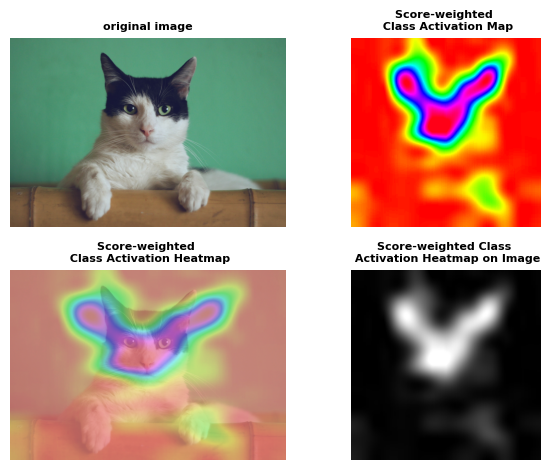

In [5]:
scorecam = scorecam_process(pret_mod, img, target_layer=11)
heatmap, heatmap_on_image, activation_map = save_class_activation_images(img, scorecam)
images = [img, heatmap, heatmap_on_image, activation_map]
captions = ['original image', 'Score-weighted \n Class Activation Map', 'Score-weighted \n Class Activation Heatmap',
            'Score-weighted Class \n Activation Heatmap on Image']
fig = download_images(images, captions, cols = 2, rows = 2, size = 8)
